In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
user_data = pd.read_csv("User Listening History.csv")
track_data = pd.read_csv("../content_based_no_model/Music_info_trimmed.csv")
msd_data_path = r'C:\Users\pouri\Desktop\study\term8\software_engineering\project\phase2\unique_tracks.txt' 
cols = ['msd_id', 'echo_nest_id','artist_name', 'track_name']
msd_df = pd.read_csv(msd_data_path, sep='<SEP>', header=None, names=cols, engine='python')
user_data.rename(columns={'track_id':'msd_id'},inplace=True)
msd_df.drop(columns=['echo_nest_id'],inplace=True)

In [3]:
print(f"num unique tracks in user_data: {user_data['msd_id'].nunique()}")

num unique tracks in user_data: 30459


In [4]:
print(msd_df.shape)

(1000000, 3)


In [5]:
msd_df.head()

,msd_id,artist_name,track_name
0,TRMMMYQ128F932D901,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,Der Mystic,Tangle Of Aspens


In [6]:
num_unique_overlapping = user_data[user_data['msd_id'].isin(msd_df['msd_id'])]['msd_id'].nunique()
print(f"num tracks overlapping in user_data and msd_df: {num_unique_overlapping}")
print("all user data songs are in msd_df")


num tracks overlapping in user_data and msd_df: 30459
all user data songs are in msd_df


In [7]:
user_data.head()

,msd_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [8]:
# Filter msd_df to keep only rows with msd_id in user_data
overlapping_df = msd_df[msd_df['msd_id'].isin(user_data['msd_id'])]

overlapping_df = overlapping_df.reset_index(drop=True)
# Display or return the result
overlapping_df.head()

,msd_id,artist_name,track_name
0,TRMMMQY128F92F0EA3,Dying Fetus,Ethos of Coercion
1,TRMMMTK128F424EF7C,Emery,Rock-N-Rule
2,TRMMWJS12903CBB7F5,Aerosmith,Remember (Walking In The Sand)
3,TRMMWCX128F92EF4C8,Alice In Videoland,Stuck On My Vision
4,TRMMWJD12903CC0F05,Gangster Fun,Brown Paper Bag


In [9]:
track_data.columns

Index(['name', 'artist', 'spotify_id', 'tags', 'year'], dtype='object')

Since MSD dataset does not include spotify IDs we had to match songs based on artist and track names.

In [10]:
# Step 1: Create lowercase versions of artist and track names in both DataFrames
overlapping_df['artist_lower'] = overlapping_df['artist_name'].str.lower()
overlapping_df['track_lower'] = overlapping_df['track_name'].str.lower()

track_data['artist_lower'] = track_data['artist'].str.lower()
track_data['track_lower'] = track_data['name'].str.lower()

# Step 2: Merge on the lowercase columns
merged_df = pd.merge(
    track_data,
    overlapping_df,
    left_on=['artist_lower', 'track_lower'],
    right_on=['artist_lower', 'track_lower'],
    how='inner'
)

# Step 3: Keep only columns from track_data
final_df = merged_df[list(track_data.columns) + ['msd_id']]

# Optional: Reset index
final_df = final_df.reset_index(drop=True)

In [11]:
final_df.drop(columns=['year', 'artist_lower', 'track_lower'],inplace=True)

In [12]:
print(f"number of matched songs: {len(final_df)}")
final_df.head()

number of matched songs: 17686


,name,artist,spotify_id,tags,msd_id
0,All These Things That I've Done,The Killers,07ygRsnqBqNFfdpmH3BeOV,"rock, alternative, indie, alternative_rock, in...",TRIWYMW128F145E0F9
1,Where Is My Mind?,Pixies,0DJU6KGwdkxEPCy3BZ3UZY,"rock, alternative, indie, alternative_rock, in...",TRNNGMK128F423F034
2,Bitter Sweet Symphony,The Verve,0jLnevC3Vn34qVWrAa4X6x,"rock, alternative, indie, pop, alternative_roc...",TRAALAH128E078234A
3,Toxicity,System of a Down,0snQkGI5qnAmohLE7jTsTn,"rock, alternative, metal, alternative_rock, ha...",TRQFICK128F92F5190
4,Heart-Shaped Box,Nirvana,0FMu3Z1yvTJKLWgxG6ZLS5,"rock, alternative, alternative_rock, 90s, grunge",TRADPIA128E078EE1B


In [13]:
user_data_spotify = pd.merge(
    user_data,
    final_df,
    on='msd_id',
    how='inner'
)[['spotify_id', 'user_id', 'playcount']]

In [14]:
len(user_data_spotify)

7730932

In [15]:
print(f"we kept {user_data_spotify['user_id'].nunique()} of {user_data['user_id'].nunique()} initial unique users")

we kept 916007 of 962037 initial unique users


<Axes: >

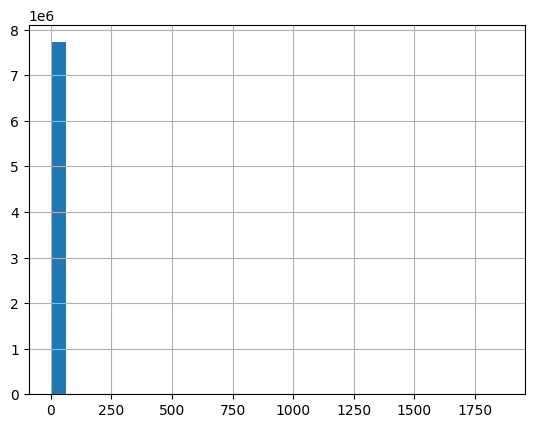

In [16]:
user_data_spotify['playcount'].hist(bins=30)

In [17]:
pd.set_option('display.max_rows', None)  # Show all rows
print(user_data_spotify['playcount'].value_counts())
pd.reset_option('display.max_rows')  # Reset to default after

playcount
1       4717162
2       1210434
3        527091
4        295121
5        287251
6        146938
7         99111
8         73087
10        55344
9         53890
11        37443
12        29778
13        23710
14        19407
15        19325
16        14936
17        12517
18        10499
20         9033
19         8910
21         7373
22         6246
23         5322
24         4815
25         4647
26         3922
27         3595
28         3114
30         2746
29         2729
31         2406
32         2203
33         1886
35         1767
34         1731
36         1510
37         1424
38         1275
39         1176
40         1147
41         1033
42          951
43          840
44          754
45          708
46          692
47          638
50          576
48          575
49          569
51          523
55          453
52          447
53          443
54          428
56          420
57          378
58          345
59          321
62          320
60          313
61          28

#### log scale (confidence)

In [18]:
alpha = 40

# 1) Compute log-scaled confidence directly
#    C = 1 + α * log1p(playcount)
user_data_spotify['confidence'] = 1 + alpha * np.log1p(user_data_spotify['playcount'])

# 2) (You no longer need log_playcount_bin or labels — drop that entire section.)

# 3) If you still want to inspect the range:
print(user_data_spotify['confidence'].describe())

count    7.730932e+06
mean     4.245693e+01
std      2.243897e+01
min      2.872589e+01
25%      2.872589e+01
50%      2.872589e+01
75%      4.494449e+01
max      3.021977e+02
Name: confidence, dtype: float64


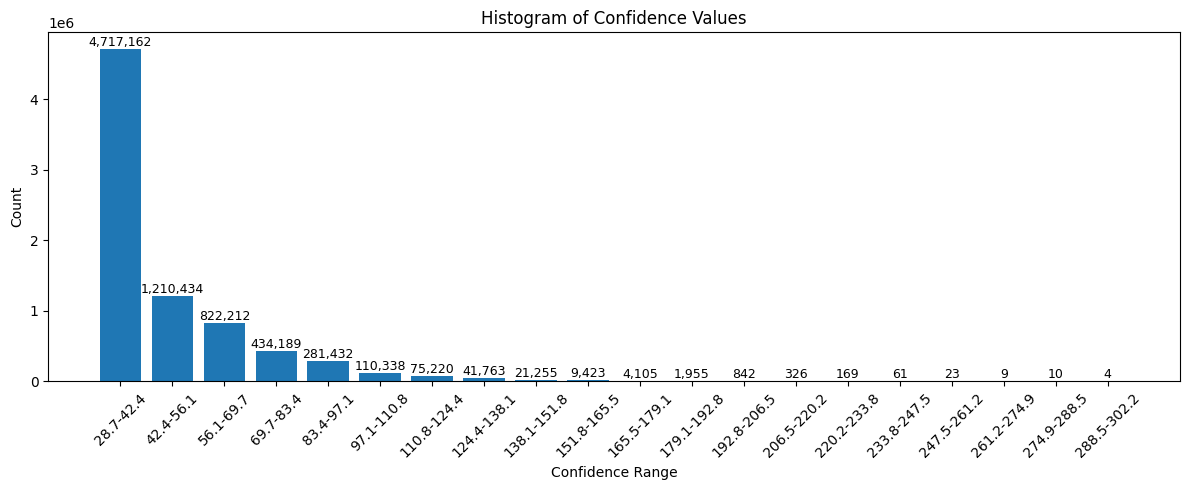

In [19]:
from matplotlib import pyplot as plt

# 1) Define how many bins you want
n_bins = 20

# 2) Grab your confidence values
values = user_data_spotify['confidence']

# 3) Compute the histogram
counts, bin_edges = np.histogram(values, bins=n_bins)

# 4) Build human-readable labels for each bin range
bin_labels = [
    f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}"
    for i in range(n_bins)
]

# 5) Plot as a bar chart
plt.figure(figsize=(12, 5))
bars = plt.bar(range(n_bins), counts, tick_label=bin_labels)

# 6) Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# 7) Tidy up
plt.title("Histogram of Confidence Values")
plt.xlabel("Confidence Range")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
user_data_spotify['confidence'].value_counts()

confidence
28.725887     4717162
44.944492     1210434
56.451774      527091
65.377516      295121
72.670379      287251
               ...   
259.270786          1
235.658722          1
236.332896          1
232.720544          1
248.612616          1
Name: count, Length: 409, dtype: int64

#### remove weak signal users

In [21]:
user_counts = user_data_spotify['user_id'].value_counts()
active_users = user_counts[user_counts >= 4].index
user_data_spotify = user_data_spotify[user_data_spotify['user_id'].isin(active_users)]
print(f"kept {len(active_users)} active users")

kept 524454 active users


In [22]:
user_data_spotify.to_csv('user_data_spotify_logscaled.csv',index=False)

In [23]:
user_data_spotify = pd.read_csv('user_data_spotify_logscaled.csv')

Double check to see if we are missing any songs from our initial spotify dataset.

In [24]:
track_ids_set = set(track_data['spotify_id'])
missing_count = (~user_data_spotify['spotify_id'].isin(track_ids_set)).sum()
print(missing_count)

0


In [25]:
# drop condifence column
df = user_data_spotify[['user_id', 'spotify_id', 'confidence']]

Prepare user-item matrix and encoders

In [26]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_idx'] = user_encoder.fit_transform(df['user_id'])
df['item_idx'] = item_encoder.fit_transform(df['spotify_id'])

# 3. Prepare sparse matrix (user-item interaction)
rows = df['user_idx'].values
cols = df['item_idx'].values
data = df['confidence'].values.astype(int)

user_item_matrix = coo_matrix((data, (rows, cols)))

In [27]:
user_item_matrix.shape

(524454, 17657)

In [29]:
import implicit

# ALS expects user-item matrix (documentaion of implicit was not up to date!)
user_item_matrix = user_item_matrix.tocsr()
print(f"user_item matrix shape: {user_item_matrix.shape}")

# 5. Train ALS model
model = implicit.als.AlternatingLeastSquares(
    factors=64,           # latent factors (you can tune)
    regularization=0.1,   # regularization parameter (you can tune)
    iterations=20,        # number of ALS iterations (you can tune)
    random_state=42       # for reproducibility
)
# Train
model.fit(user_item_matrix, show_progress=True)


user_item matrix shape: (524454, 17657)


  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
df.shape

(6991291, 5)

In [31]:
usr = 1
print(df.iloc[usr])
print('########')
user_id = df['user_id'].iloc[usr]
user_idx = df['user_idx'].iloc[usr]
if user_encoder.transform([user_id])[0] != user_idx:
    print("User ID mismatch!")
print(f"user id: {user_id}")
print(f"user idx: {user_idx}")

user_id       b80344d063b5ccb3212f76538f3d9e43d87dca9e
spotify_id                      079ZOccLpNsrEiKBaiTrqI
confidence                                   28.725887
user_idx                                        376902
item_idx                                          1392
Name: 1, dtype: object
########
user id: b80344d063b5ccb3212f76538f3d9e43d87dca9e
user idx: 376902


In [32]:
user_item_matrix[user_idx]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 17657)>

In [33]:
user_idx

np.int64(376902)

In [52]:
recommended_idx, recommended_scores = model.recommend(
    userid=user_idx,
    user_items=user_item_matrix[user_idx],
    N=10,                # number of recommendations
    filter_already_liked_items=True  # don’t recommend what user already played
)


In [53]:
recommended_spotify_ids = item_encoder.inverse_transform(recommended_idx)
print("Top 10 recommended song IDs:", recommended_spotify_ids)

Top 10 recommended song IDs: ['039Q3UlFQ6kavVIZHpO4mL' '1CFwwYZ58s34axN637i9Gq'
 '1wDUd3PBbLm1fNipGJYODZ' '1v1MoRe2yzHnXCkHSTMB56'
 '0naTARZScsZOtx3nlhlq0Y' '0BatdOxGWlJdi3WuooZySi'
 '0ztrXQTOGEltWSaR4l3rNg' '15ioAEmEbXr4zaXWx21UU3'
 '0GJnTFZJql2Dqb4uhckURe' '12NB90vCkFaZKagYCZC66c']


Extract recommendations

In [59]:
recommended = track_data[track_data['spotify_id'].isin(recommended_spotify_ids)]

#### user listening history

In [55]:
user_data_spotify[user_data_spotify['user_id'] == user_id]['spotify_id'].shape

(15,)

In [56]:
single_user_history_df = track_data[track_data['spotify_id'].isin(user_data_spotify[user_data_spotify['user_id'] == user_id]['spotify_id'])][['name','artist','tags']]
print(user_data_spotify[user_data_spotify['user_id'] == user_id]['spotify_id'].shape[0] == single_user_history_df.shape[0])

True


In [57]:
single_user_history_df

,name,artist,tags
796,Ragged Wood,Fleet Foxes,"rock, alternative, indie, folk, indie_rock, 00..."
1158,He Doesn't Know Why,Fleet Foxes,"rock, alternative, indie, folk, indie_rock, am..."
1743,Love Shack,The B-52's,"rock, alternative, pop, dance, 80s, new_wave"
2350,Paper Gangsta,Lady Gaga,"electronic, pop, female_vocalists, dance, pian..."
2585,All That We Perceive,Thievery Corporation,"electronic, ambient, chillout, trip_hop, downt..."
5411,Stacked Actors,Foo Fighters,"rock, alternative, alternative_rock, hard_rock..."
5423,Generator,Foo Fighters,"rock, alternative, alternative_rock, hard_rock..."
5814,Sun Giant,Fleet Foxes,"alternative, indie, folk, acoustic, american, ..."
8649,Gimme Stitches,Foo Fighters,"rock, alternative_rock, hard_rock, grunge"
8740,City Love,John Mayer,"rock, alternative, jazz, singer_songwriter, ac..."


#### recommended to user

In [58]:
recommended[['name','artist','tags']]

,name,artist,tags
323,Revelry,Kings of Leon,"rock, alternative, indie, alternative_rock, in..."
860,Tiger Mountain Peasant Song,Fleet Foxes,"rock, alternative, indie, folk, acoustic, beau..."
1199,Sun It Rises,Fleet Foxes,"rock, alternative, indie, folk, indie_rock, ac..."
1340,Staple It Together,Jack Johnson,"rock, alternative, pop, folk, singer_songwrite..."
1550,Oliver James,Fleet Foxes,"rock, alternative, indie, folk, acoustic, 00s"
1876,Heartbreak Warfare,John Mayer,"rock, alternative, indie, pop, singer_songwrit..."
5244,Bubble Toes,Jack Johnson,"alternative, pop, folk, singer_songwriter, chi..."
8605,Skin and Bones,Foo Fighters,"rock, alternative_rock, hard_rock, 90s, acoust..."
12399,The News,Jack Johnson,"folk, singer_songwriter, chillout, acoustic, m..."
16774,You And Your Heart,Jack Johnson,"rock, pop, singer_songwriter, acoustic, love, ..."


---

### adding new user

In [47]:
len(model.user_factors)

524455

In [62]:
from scipy.sparse import csr_matrix
import numpy as np
new_user_idx = model.user_factors.shape[0] -1
num_items = model.item_factors.shape[0]
item_indices = np.array([200,201,202,203]) 
values = np.ones_like(item_indices)
new_user_interactions = csr_matrix((values, ([0]*len(item_indices), item_indices)), shape=(1, num_items))

In [ ]:
new_user_interactions

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4 stored elements and shape (1, 17657)>

In [64]:
model.partial_fit_users([new_user_idx], new_user_interactions)

In [65]:
len(model.user_factors)
len(user_encoder.classes_)

264284

In [66]:
recommended_idx, recommended_scores= model.recommend(
    userid=new_user_idx,
    user_items=new_user_interactions,
    N=10,
    filter_already_liked_items=True
)

In [ ]:
recommended = track_data[track_data['spotify_id'].isin(recommended_idx)]
recommended_idx = item_encoder.inverse_transform(recommended_idx)
print("Top 10 recommended song IDs:", recommended_idx)

Top 10 recommended song IDs: ['1NhfOyO3Bo3LUZ1l2DOnvQ' '02Ug0gh7jThCGewfOYWOMZ'
 '01MXJ7LZZ3SQajMGE4AzgH' '4HyhcY8J1NWnOu1YjUwy6h'
 '0D3PEOYrlZAFZCg2oPmI9l' '2KBPf6pPYOlfAXpn09nwlv'
 '2ubHoHRIiw6GZdSuPSmxJL' '01M3WpV7p7CkbdDafVlFbS'
 '1MWoir4vE3FBSF7O01zL0i' '12IzNf6vFmMVeRw2H4LkgM']


In [68]:
track_data[track_data['spotify_id'].isin(recommended_idx)][['name','artist','tags']]

,name,artist,tags
3146,Twilight Galaxy,Metric,"rock, electronic, indie, female_vocalists, ind..."
13335,Gin & Milk,Dirty Pretty Things,"indie, punk, indie_rock, british"
26578,Supercrush!,Devin Townsend Project,progressive_metal
35385,The Cry of Mankind,My Dying Bride,doom_metal
36127,Beautiful Delilah,Chuck Berry,"classic_rock, oldies"
38643,Building The Church,Steve Vai,guitar
38828,Table Tennis ft. Laura Darlington,Flying Lotus,idm
39521,Seductive Barry,Pulp,britpop
42602,The Returning,Dragonland,"power_metal, symphonic_metal"
42895,Blue Line Cretin,The Red Chord,"metalcore, grindcore, avant_garde"


In [69]:
spotify_ids = item_encoder.inverse_transform(item_indices)
spotify_ids

array(['00wj7uXIbVEVX6ZfD2DZy6', '00wuSL9a93zQQkNJNQ2KzK',
       '00xrSZwKt8BZWF5Lv5gVuB', '00yPOgKVyqp9bYEq8FQb9q'], dtype=object)

In [ ]:
track_data[track_data['spotify_id'].isin(spotify_ids)]

,name,artist,spotify_id,tags,year
4371,The Perfect Fit,The Dresden Dolls,00wj7uXIbVEVX6ZfD2DZy6,"female_vocalists, punk_rock, acoustic, piano",2004
19934,Red Is The New Black,Funeral for a Friend,00xrSZwKt8BZWF5Lv5gVuB,"rock, hardcore, emo, post_hardcore, screamo",2003
27607,Donut (Interpretation),Booka Shade,00wuSL9a93zQQkNJNQ2KzK,"electronic, dance, german, techno",2010
33172,Easy Silence,Dixie Chicks,00yPOgKVyqp9bYEq8FQb9q,country,2010


### convert required files to pickle and ..

In [ ]:
from pathlib import Path

DATA_DIR = Path("artifacts")
USER_ENC_PATH = DATA_DIR / "user_encoder.pkl"
ITEM_ENC_PATH = DATA_DIR / "item_encoder.pkl"  # immutable
MATRIX_PATH = DATA_DIR / "user_item_matrix.pkl"  # CSR, pickled
MUSIC_INFO_PATH = DATA_DIR / "music_info_trimmed.parquet"  # optional


In [ ]:
# Save user_encoder
with open(USER_ENC_PATH, "wb") as f:
    pickle.dump(user_encoder, f)

# Save item_encoder
with open(ITEM_ENC_PATH, "wb") as f:
    pickle.dump(item_encoder, f)

# Save user_item_matrix
with open(MATRIX_PATH, "wb") as f:
    pickle.dump(user_item_matrix, f)

track_data.to_parquet(MUSIC_INFO_PATH, engine="pyarrow") 